<h1 style="text-align:center;">MNIST curvature slices 🧀</h1>

In [1]:
import itertools
import sys
import math
from tqdm import tqdm

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.optim import SGD

sys.path.append("..")
from fromage import Fromage

## Download the data and put it into Pytorch dataloaders
My GPU is very big so I can run a test batch size of 10,000. You may need to reduce this if you get out-of-memory errors.

In [2]:
train_batch_size = 250
test_batch_size = 10000

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=train_batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=test_batch_size, shuffle=True)

## Define the multilayer perceptron architecture
Note that the total number of layers is `num_layers + 1` to include the output layer.

In [3]:
class SimpleNet(nn.Module):
    def __init__(self, num_layers, residual):
        super(SimpleNet, self).__init__()
        self.layers = nn.ModuleList([nn.Linear(784, 784) for _ in range(num_layers)])
        self.final = nn.Linear(784, 10)
        self.residual = residual
        
    def forward(self, x):
        for layer in self.layers:
            if self.residual:
                x = x + F.relu(layer(x))
            else:
                x = F.relu(layer(x))
        return self.final(x)
    
def getLR(optimizer):
    for param_group in optimizer.param_groups:
        print(f"lr is {param_group['lr']}")
    
net = SimpleNet(3,residual=False)
for p in net.parameters():
    print(p.size())

torch.Size([784, 784])
torch.Size([784])
torch.Size([784, 784])
torch.Size([784])
torch.Size([784, 784])
torch.Size([784])
torch.Size([10, 784])
torch.Size([10])


## Train the MLP for 10 epochs
We save 10 model checkpoints. For `layer_num = 1` or `residual = True`, the interesting behaviour is during the first epoch, so we record more frequently there.

Training 1 layers, fromage optim, learning rate 0.01
epoch 0
lr is 0.01
100%|██████████| 240/240 [00:05<00:00, 44.57it/s]


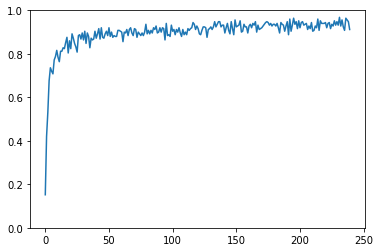

epoch 1
lr is 0.009000000000000001
100%|██████████| 240/240 [00:05<00:00, 45.23it/s]


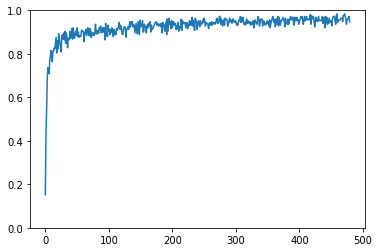

epoch 2
lr is 0.008100000000000001
100%|██████████| 240/240 [00:05<00:00, 45.50it/s]


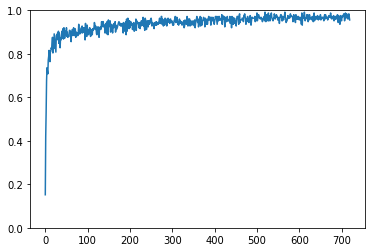

epoch 3
lr is 0.007290000000000001
100%|██████████| 240/240 [00:05<00:00, 46.90it/s]


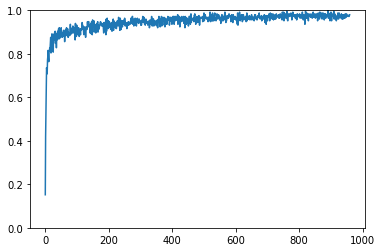

epoch 4
lr is 0.006561
100%|██████████| 240/240 [00:05<00:00, 45.71it/s]


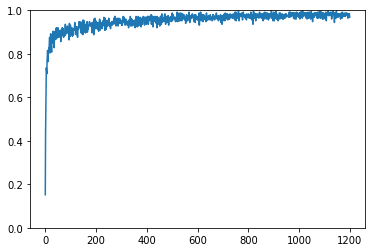

epoch 5
lr is 0.005904900000000001
100%|██████████| 240/240 [00:05<00:00, 46.22it/s]


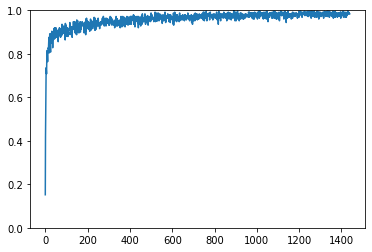

epoch 6
lr is 0.00531441
100%|██████████| 240/240 [00:05<00:00, 47.91it/s]


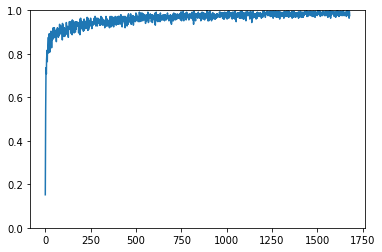

epoch 7
lr is 0.004782969000000001
100%|██████████| 240/240 [00:05<00:00, 46.84it/s]


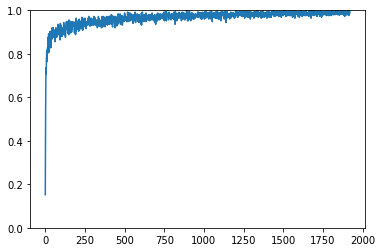

epoch 8
lr is 0.004304672100000001
100%|██████████| 240/240 [00:05<00:00, 46.38it/s]


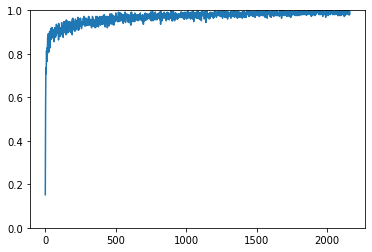

epoch 9
lr is 0.003874204890000001
100%|██████████| 240/240 [00:05<00:00, 46.18it/s]


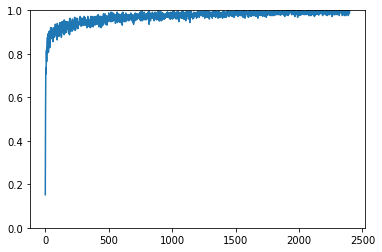

test acc 0.9803


In [4]:
results_dict = {}

residual = False
# layer_num = 15
layer_num = 1
epochs = 10
# opt = "SGD"
opt = "fromage"

# Here we set up a list of (Epoch, Iteration) tuples for when to save checkpoints:
if layer_num == 15 and not residual:
    it_list = [(epoch,0) for epoch in range(10)]
else:
    it_list = [(0,0),(0,12),(0,24),(0,48),(0,96)] + [(1,0),(3,0),(5,0),(7,0),(9,0)]

lr_lambda = lambda x: 0.9**x

model = SimpleNet(layer_num, residual).cuda()
loss_fn = torch.nn.CrossEntropyLoss()

if opt == "fromage":
    learning_rate = 0.01
    optim = Fromage(model.parameters(), lr=learning_rate)
elif opt == "SGD":
    learning_rate = 0.1
    optim = SGD(model.parameters(), lr=learning_rate, momentum=0.0)
lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optim, lr_lambda)

print("Training {} layers, {} optim, learning rate {}".format(layer_num, opt, learning_rate))

model.train()
training_acc = []
for epoch in range(epochs):
    print(f"epoch {epoch}")
    getLR(optim)
    
    for batch_idx, (data, target) in enumerate(tqdm(train_loader, file=sys.stdout)):
        if (epoch,batch_idx) in it_list:
            print(f"recording at epoch {epoch} batch idx {batch_idx}")
            torch.save(model.state_dict(), f"curvature_checkpoints/depth{layer_num}epoch{epoch}batch{batch_idx}.ckpt")
        data, target = (data.cuda(), target.cuda())

        data = data.view(train_batch_size,-1)
        y_pred = model(data)
        loss = loss_fn(y_pred, target)

        acc = (target == y_pred.max(dim=1)[1]).sum().item() / train_batch_size
        training_acc.append(acc)

        model.zero_grad()
        loss.backward()
        optim.step()
    lr_scheduler.step()
    plt.plot(training_acc)
    plt.ylim(0,1)
    plt.show()

model.eval()
testing_acc = 0
for batch_idx, (data, target) in enumerate(test_loader):
    data, target = (data.cuda(), target.cuda())
    
    data = data.view(test_batch_size,-1)
    y_pred = model(data)
    
    acc = (target == y_pred.max(dim=1)[1]).sum().item()/test_batch_size
    testing_acc += acc
testing_acc = testing_acc/float(len(test_loader))
print(f"test acc {testing_acc}")

## Record slices
We loop over the saved checkpoints and record slices of the loss function and the relative change in gradient.

In [5]:
steps = 100
eta = 0.001
grad_layer = 0

epoch_losses = []
epoch_grads = []
for epoch,batch_idx in it_list:
    print(f"epoch {epoch} batch_idx {batch_idx}")
    model = SimpleNet(layer_num, residual).cuda()

    loss_fn = torch.nn.CrossEntropyLoss()
    model.load_state_dict(torch.load(f"curvature_checkpoints/depth{layer_num}epoch{epoch}batch{batch_idx}.ckpt"))
    model.train()

    full_batch_size = 60000 # you may need to reduce this if you don't have a big GPU.
    full_batch_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=full_batch_size, shuffle=True)

    data, target = next(iter(full_batch_loader))
    data, target = (data.cuda(), target.cuda())

    print("Running forward pass")
    data = data.view(full_batch_size,-1)
    y_pred = model(data)
    loss = loss_fn(y_pred, target)

    print("Running backward pass")
    model.zero_grad()
    loss.backward()
    
    model_gradients = []
    model_pnorms = []
    for p in model.parameters():
        model_gradients.append(p.grad.data*1.0) # multiply by 1.0 to get a copy
        model_pnorms.append(p.norm().item()*1.0) # multiply by 1.0 to get a copy

    losses = []
    grads = []

    for step_idx in tqdm(range(steps),file=sys.stdout):
        y_pred = model(data)
        loss = loss_fn(y_pred, target)
        losses.append(loss.item())
        
        model.zero_grad()
        loss.backward()
        
        g_current = list(model.parameters())[grad_layer].grad.data
        g_start = model_gradients[grad_layer]
        assert(g_current.shape == (784,784))
        g_diff = g_current - g_start
        grads.append(g_diff.norm() / g_start.norm())
        
        for p,g,pnorm in zip(model.parameters(),model_gradients,model_pnorms):
            if g.norm() > 0:
                p.data -= eta * g * pnorm / g.norm()
                
    epoch_losses.append(losses)
    epoch_grads.append(grads)

epoch 0 batch_idx 0
Running forward pass
Running backward pass
100%|██████████| 100/100 [00:02<00:00, 45.95it/s]
epoch 0 batch_idx 12
Running forward pass
Running backward pass
100%|██████████| 100/100 [00:02<00:00, 47.09it/s]
epoch 0 batch_idx 24
Running forward pass
Running backward pass
100%|██████████| 100/100 [00:02<00:00, 47.70it/s]
epoch 0 batch_idx 48
Running forward pass
Running backward pass
100%|██████████| 100/100 [00:02<00:00, 48.09it/s]
epoch 0 batch_idx 96
Running forward pass
Running backward pass
100%|██████████| 100/100 [00:02<00:00, 47.93it/s]
epoch 1 batch_idx 0
Running forward pass
Running backward pass
100%|██████████| 100/100 [00:02<00:00, 46.95it/s]
epoch 3 batch_idx 0
Running forward pass
Running backward pass
100%|██████████| 100/100 [00:02<00:00, 46.54it/s]
epoch 5 batch_idx 0
Running forward pass
Running backward pass
100%|██████████| 100/100 [00:02<00:00, 45.00it/s]
epoch 7 batch_idx 0
Running forward pass
Running backward pass
100%|██████████| 100/100 [00:

## Plot the results

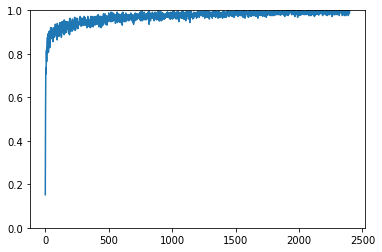

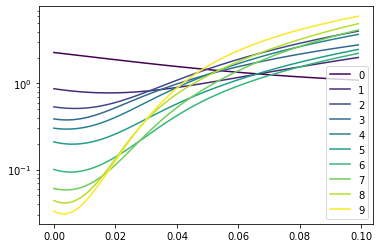

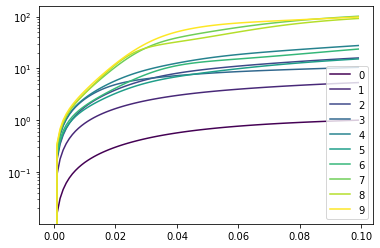

In [6]:
plt.plot(training_acc)
plt.ylim(0,1)
plt.show()

def plot(curves):
    epochs = 10
    colors = plt.cm.viridis(np.linspace(0,1,epochs))
    for epoch in range(epochs):
        curve = curves[epoch]
        plt.plot(np.array(range(100))*0.001, curve, color=colors[epoch])
    plt.yscale('log')
    plt.legend(range(epochs))
    plt.show()

plot(epoch_losses)
plot(epoch_grads)

## Save the slices and the training accuracy

In [7]:
np.save(f'logs/curvature/residual{residual}_depth{layer_num}_loss_slices',epoch_losses)
np.save(f'logs/curvature/residual{residual}_depth{layer_num}_grad_changes',epoch_grads)
np.save(f'logs/curvature/residual{residual}_depth{layer_num}_training_acc',training_acc)